In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import scipy.io
import ipdb
import math
import torch
import pytorch_wavelets.dwt.lowlevel as lowlevel
from pytorch_wavelets import DWTForward, DWTInverse


In [136]:
class DWT2D(torch.nn.Module):
    """ Performs a 2d DWT Forward decomposition of an image
    Args:
        J (int): Number of levels of decomposition
        wave (str or pywt.Wavelet): Which wavelet to use. Can be a string to
            pass to pywt.Wavelet constructor, can also be a pywt.Wavelet class,
            or can be a two tuple of array-like objects for the analysis low and
            high pass filters.
        mode (str): 'zero', 'symmetric', 'reflect' or 'periodization'. The
            padding scheme
        separable (bool): whether to do the filtering separably or not (the
            naive implementation can be faster on a gpu).
        """
    def __init__(self, J=1, wave='db1', mode='zero'):
        super().__init__()
        
        # make analysis filters
        all_filters = self.make_filters()
        
        filts = all_filters[0]
        self.h0_col = filts[0]
        self.h1_col = filts[1]
        self.h0_row = filts[2]
        self.h1_row = filts[3]
        

        filts = all_filters[1]
        self.g0_col = filts[0]
        self.g1_col = filts[1]
        self.g0_row =filts[2]
        self.g1_row =filts[3]

        self.J = J
        self.mode = mode
        
    def make_filters(self):
        #self.s = torch.nn.Parameter(torch.tensor([1/math.sqrt(2)]), requires_grad=True)

        self.theta1 = torch.nn.Parameter(torch.tensor([math.pi/4]))
        self.theta2 = torch.nn.Parameter(torch.tensor([math.pi/6]))
        
        c1 = torch.cos(self.theta1)
        s1 = torch.sin(self.theta1)

        c2 = torch.cos(self.theta2)
        s2 = torch.sin(self.theta2)

        h0 = torch.cat( [c1*c2,  c2*s1, - s1*s2,  c1*s2])
        h1 = torch.cat([- c1*s2, - s1*s2, - c2*s1,  c1*c2])
        f0 = torch.cat( [c1*s2, - s1*s2,  c2*s1, c1*c2])
        f1 = torch.cat([c1*c2, - c2*s1, - s1*s2, - c1*s2])

        h0_col = h0.reshape((1,1,-1,1))
        h1_col = h1.reshape((1,1,-1,1))
        h0_row = h0_col.reshape((1,1,1,-1))
        h1_row = h1_col.reshape((1,1,1,-1))
        
        f0_col = f0.reshape((1,1,-1,1))
        f1_col = f1.reshape((1,1,-1,1))
        f0_row = f0_col.reshape((1,1,1,-1))
        f1_row = f1_col.reshape((1,1,1,-1))


        return (h0_col, h1_col, h0_row, h1_row), (f0_col, f1_col, f0_row, f1_row)
        
    def do_reconstruct(self, coeffs):
        """
        Args:
            coeffs (yl, yh): tuple of lowpass and bandpass coefficients, where:
              yl is a lowpass tensor of shape :math:`(N, C_{in}, H_{in}',
              W_{in}')` and yh is a list of bandpass tensors of shape
              :math:`list(N, C_{in}, 3, H_{in}'', W_{in}'')`. I.e. should match
              the format returned by DWTForward
        Returns:
            Reconstructed input of shape :math:`(N, C_{in}, H_{in}, W_{in})`
        Note:
            :math:`H_{in}', W_{in}', H_{in}'', W_{in}''` denote the correctly
            downsampled shapes of the DWT pyramid.
        Note:
            Can have None for any of the highpass scales and will treat the
            values as zeros (not in an efficient way though).
        """
        yl, yh = coeffs
        ll = yl
        mode = lowlevel.mode_to_int(self.mode)

        # Do a multilevel inverse transform
        for h in yh[::-1]:
            if h is None:
                h = torch.zeros(ll.shape[0], ll.shape[1], 3, ll.shape[-2],
                                ll.shape[-1], device=ll.device)

            # 'Unpad' added dimensions
            if ll.shape[-2] > h.shape[-2]:
                ll = ll[...,:-1,:]
            if ll.shape[-1] > h.shape[-1]:
                ll = ll[...,:-1]
            ll = lowlevel.SFB2D.apply(
                ll, h, self.g0_col, self.g1_col, self.g0_row, self.g1_row, mode)
        return ll

    def do_synthesize(self,x):
        """ Forward pass of the DWT.
        Args:
            x (tensor): Input of shape :math:`(N, C_{in}, H_{in}, W_{in})`
        Returns:
            (yl, yh)
                tuple of lowpass (yl) and bandpass (yh)
                coefficients. yh is a list of length J with the first entry
                being the finest scale coefficients. yl has shape
                :math:`(N, C_{in}, H_{in}', W_{in}')` and yh has shape
                :math:`list(N, C_{in}, 3, H_{in}'', W_{in}'')`. The new
                dimension in yh iterates over the LH, HL and HH coefficients.
        Note:
            :math:`H_{in}', W_{in}', H_{in}'', W_{in}''` denote the correctly
            downsampled shapes of the DWT pyramid.
        """
        yh = []
        ll = x
        mode = lowlevel.mode_to_int(self.mode)

        # Do a multilevel transform
        for j in range(self.J):
            # Do 1 level of the transform
            ll, high = lowlevel.AFB2D.apply(
                ll, self.h0_col, self.h1_col, self.h0_row, self.h1_row, mode)
            yh.append(high)

        return ll, yh
    
    def forward(self, x, type='s'):
        if type=='s':
            return self.do_synthesize(x)
        if type=='r':
            return self.do_reconstruct(x)


In [134]:
a=1; b=2; c=6; d =1; e=-2
# h0 : deg 4 -> -4 9 
# h1 # deg 3 -> -3 7
h0 = [a*b*c*d*e,  b*c*d*e,  (a*b*e + a*d*e + c*d*e + 4*a*b*c*d*e),  (b*e + d*e + 3*b*c*d*e),  (e + 2*a*b*e + 2*a*d*e + 2*c*d*e + 6*a*b*c*d*e),  (b*e + d*e + 3*b*c*d*e),  (a*b*e + a*d*e + c*d*e + 4*a*b*c*d*e),  b*c*d*e, a*b*c*d*e]
h1 = [a*b*c/e,  b*c/e,  (a + c + 3*a*b*c)/e, (2*b*c + 1)/e, (a + c + 3*a*b*c)/e, b*c/e, a*b*c/e, 0,0]
f0 = [- a*b*c/e, b*c/e, (- a - c - 3*a*b*c)/e,  (2*b*c + 1)/e,  (- a - c - 3*a*b*c)/e, b*c/e, - a*b*c/e,0,0 ] 
f1 = [a*b*c*d*e, - b*c*d*e, (a*b*e + a*d*e + c*d*e + 4*a*b*c*d*e), (- b*e - d*e - 3*b*c*d*e), (e + 2*a*b*e + 2*a*d*e + 2*c*d*e + 6*a*b*c*d*e), (- b*e - d*e - 3*b*c*d*e), (a*b*e + a*d*e + c*d*e + 4*a*b*c*d*e),-b*c*d*e, a*b*c*d*e]

In [137]:
mat = scipy.io.loadmat('boat.mat')
X = mat['x']
X = torch.tensor(x).unsqueeze(0).float()

/data2/minh/packages/miniconda3/envs/pytorch13py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [119]:
h1

[-6.0, -6.0, -21.5, -12.5, -21.5, -6.0, -6.0, 0, 0]

In [138]:
theta1 = torch.tensor([math.pi/4])
theta2 = torch.tensor([math.pi/6])
c1 = torch.cos(theta1)
s1 = torch.sin(theta1)

c2 = torch.cos(theta2)
s2 = torch.sin(theta2)

h0 = torch.cat( [c1*c2,  c2*s1, - s1*s2,  c1*s2])
h1 = torch.cat([- c1*s2, - s1*s2, - c2*s1,  c1*c2])
f0 = torch.cat( [c1*s2, - s1*s2,  c2*s1, c1*c2])
f1 = torch.cat([c1*c2, - c2*s1, - s1*s2, - c1*s2])



In [129]:
xfm  = DWT2D(J=1)
Yl, Yh = xfm(X,'s')
Y = xfm((Yl, Yh),'r')


In [131]:
Y

tensor([[[[  0.2500,  -0.2500,  -0.2500,  ...,   1.5000,   0.7500,   0.7500],
          [ -0.2500,   0.2500,   0.2500,  ...,  -1.5000,  -0.7500,  -0.7500],
          [ -0.2500,   0.2500, 168.0000,  ..., 135.7500, 133.5000, 133.5000],
          ...,
          [ -3.5000,   3.5000, 153.0000,  ...,  99.2500, 102.7500, 102.7500],
          [  4.5000,  -4.5000, 141.2500,  ..., 122.2500, 143.2500, 143.2500],
          [  4.5000,  -4.5000, 141.2500,  ..., 122.2500, 143.2500, 143.2500]]]],
       grad_fn=<SFB2DBackward>)

In [145]:
from pytorch_wavelets import DWTForward, DWTInverse
xfm = DWTForward(J=1, wave=(h0,h1))
Yl, Yh = xfm(X)
ifm = DWTInverse(wave='db3', mode='zero')
Y = ifm((Yl, Yh))

ValueError: negative step not yet supported

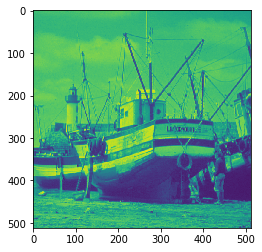

In [143]:
plt.imshow(Y.squeeze())